#### - The objective of this notebook is to train a neural network to learn how to price a swaption for a given underlying model. As input to the neural network, we will consider the zero rate curve and the model parameters.  

#### - What we want to "predict" is a Bachelier implied volatility grid for a given strike and expiry of the option. 

#### - The benefit of this exercise is that once the neural network is trained, we have an approximation of the implied volality extremely quickly.  In a calibration exercise, we can then replace the underlying pricing model which can take a long time to compute and replace it with the neural network.

**Reference**: Horvath, B., Muguruza, A. and Tomas, M., 2019. Deep Learning Volatility. Available at SSRN 3322085.

In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
# Note down the grid we shall be using.

strike = np.arange(-0.02, 0.025, step=0.005)
optMats = [0.5, 1, 2, 5, 10, 15, 20, 30]
grid = {
    'chgStrike' : strike,
    'optMat' : optMats
}
keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]
combinations = pd.DataFrame(combinations)
print("Number of combinations:",len(combinations))
print(len(strike), len(optMats))

Number of combinations: 72
9 8


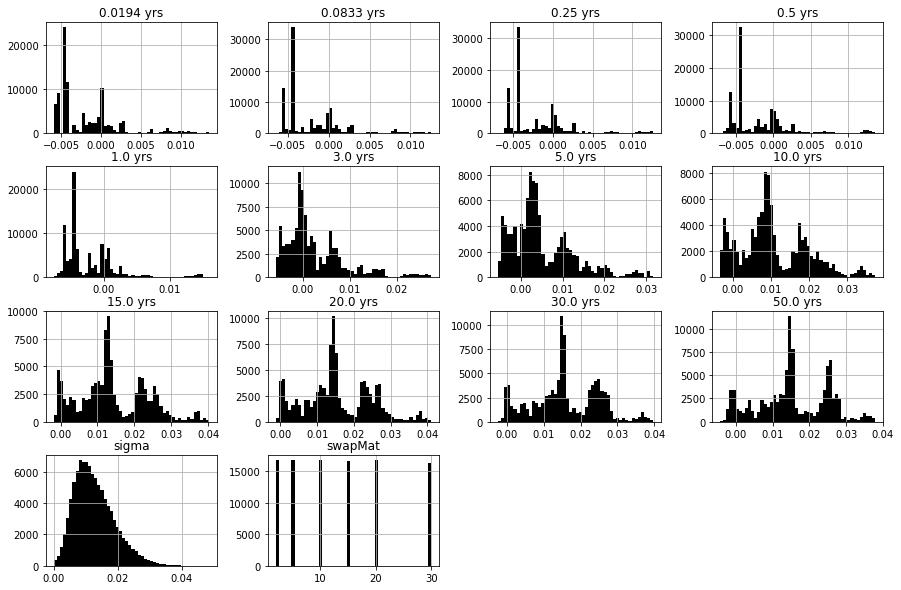

In [4]:
# Import data
X = pd.read_csv(f"data/2DpricingVector-input.csv.gz")
X["sigma"] = np.maximum(X["sigma"], 1e-12)
y = pd.read_csv(f"data/2DgridImpliedVolatility.csv.gz")

X.hist(figsize=(15,10), bins=50, color="black");
plt.savefig("plots/histogramInput.png")
plt.show()

#### Data transformations:
- We apply PCA on the curve and keep the first 4 components.  The curve is standardized before applying PCA on it
- We scale the input data between -1 and 1
- We standardize the implied volatility $\frac{\sigma - mean(\sigma)}{std(\sigma)}$

In [5]:
usePCA = True

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Split train test
TRAINING_SIZE = 0.8
split = int(TRAINING_SIZE*X.shape[0])
X_tr, X_te = X[:split].reset_index(drop=True), X[split:].reset_index(drop=True)
y_tr, y_te = y[:split].reset_index(drop=True), y[split:].reset_index(drop=True)

# Extract curve
curveCols = X.columns[X.columns.str.contains("yrs")]
curve_tr, curve_te = X_tr[curveCols].copy(), X_te[curveCols].copy()

if usePCA:
    # Std scaler
    scaler = StandardScaler()
    curve_tr_sc, curve_te_sc = scaler.fit_transform(curve_tr), scaler.transform(curve_te)
    # PCA
    comps=3
    pca = PCA(n_components=comps)
    curve_tr_pca, curve_te_pca = pca.fit_transform(curve_tr_sc), pca.transform(curve_te_sc)
    curve_tr_pca, curve_te_pca = pd.DataFrame(curve_tr_pca), pd.DataFrame(curve_te_pca)
    colNames = [f"comp_{x}" for x in range(0, comps)]
    curve_tr_pca.columns, curve_te_pca.columns = colNames, colNames
    # Merge data 
    X_tr_clean = pd.concat([curve_tr_pca, X_tr.drop(columns=curveCols)], axis=1)
    X_te_clean = pd.concat([curve_te_pca, X_te.drop(columns=curveCols)], axis=1)
    # Scale between -1 and 1
    rng = MinMaxScaler(feature_range=(-1, 1))
    X_tr_clean, X_te_clean = rng.fit_transform(X_tr_clean), rng.transform(X_te_clean)
else:
    rng = rng = MinMaxScaler(feature_range=(-1, 1))
    X_tr_clean, X_te_clean = rng.fit_transform(X_tr), rng.transform(X_te)

scaleY = StandardScaler()
y_tr_clean, y_te_clean = scaleY.fit_transform(y_tr), scaleY.transform(y_te) 

Define and train NN

In [7]:
import keras
from keras import backend as K
keras.backend.set_floatx('float64')

def rmse(y_true, y_pred):
    """Root mean square error loss"""
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_model():
    """Initialize model"""
    input1 = keras.layers.Input(shape=(X_tr_clean.shape[1],))
    x1 = keras.layers.Dense(32,activation = 'elu')(input1)
    x2=keras.layers.Dense(32,activation = 'elu')(x1) 
    x3=keras.layers.Dense(32,activation = 'elu')(x2) 
    output1=keras.layers.Dense(y_tr_clean.shape[1],activation = 'linear')(x3)

    model = keras.models.Model(inputs=input1, outputs=output1)
    print(model.summary())
    return model

#### Uncomment if you want to train the NN again.  No need to do so as it has been save in .h5 file.
# model = create_model() 
# model.compile(loss=rmse, optimizer="adam")
# 
# earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
# lrReduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", verbose=1, patience=8)
# 
# history = model.fit(
#     x=X_tr_clean,
#     y=y_tr_clean,
#     batch_size=32,
#     epochs=200,
#     validation_split=0.2,
#     callbacks=[earlyStop, lrReduce]
# )
# 
# model.save_weights(f"savedNN/model-impliedVol-pca{usePCA}.h5")

# Plot training metrics
#plt.plot(history.history["loss"], label="Training", color="black")
#plt.plot(history.history["val_loss"], label="Validation", color="orange")
#plt.title("Loss")
#plt.xlabel("Epochs")
#plt.ylabel("Loss Metric")
#plt.yscale("log")
#plt.legend()
#plt.savefig("plots/NN-learningHist.png")
#plt.show()

In [8]:
# Load the saved model
model = create_model()
model.load_weights(f"savedNN/model-impliedVol-pca{usePCA}.h5")

# Compute predictions
pred_oos = model.predict(X_te_clean)
pred_oos = scaleY.inverse_transform(pred_oos)

def r2score(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )
def rmse_np(y_true, y_pred):
    return np.sqrt( np.mean( (y_true - y_pred)**2 ) )

rmse_score = rmse_np(y_te.values, pred_oos)
print("RMSE:",rmse_score)

r2 = r2score(y_te.values, pred_oos)
print("R^2:", r2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                2376      
Total params: 4,680
Trainable params: 4,680
Non-trainable params: 0
_________________________________________________________________
None
RMSE: 0.00013741141011885363
R^2: 0.9990695016948327


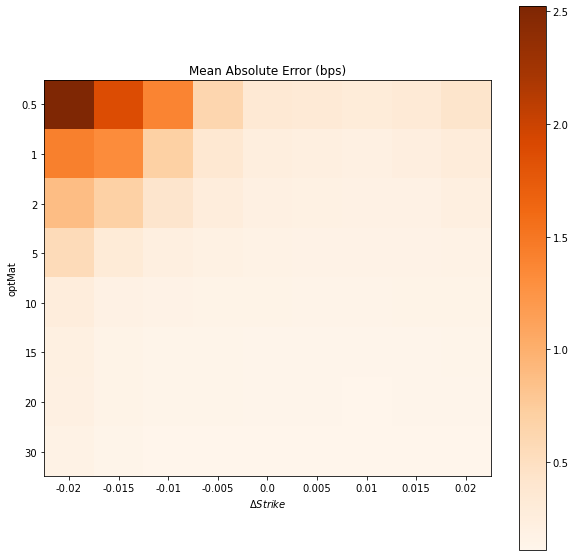

In [9]:
error = 10000 * np.mean(np.abs(pred_oos - y_te.values), axis=0) # Absolute error in bps
errDf = pd.DataFrame(error.reshape(len(strike), len(optMats)).T, index=optMats, columns=np.around(strike,4))

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(errDf, cmap="Oranges")
plt.colorbar()
ax.set_xticks(range(0,len(strike)))
ax.set_xticklabels(np.around(strike,3))
ax.set_yticks(range(0, len(optMats)))
ax.set_yticklabels(optMats)
ax.set_xlabel(r"$\Delta Strike$")
ax.set_ylabel("optMat")
plt.title("Mean Absolute Error (bps)")
plt.savefig("plots/matrixMeanAbsError-bps.png")
plt.show()

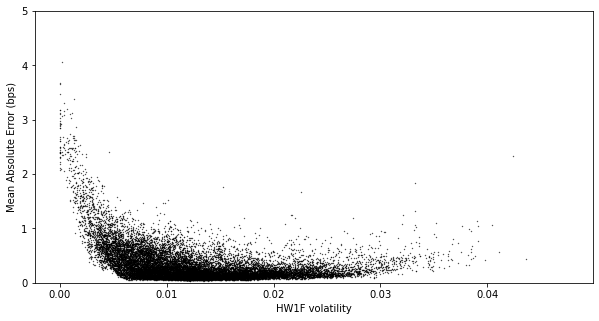

In [10]:
errorAxis = 10000 * np.mean(np.abs(pred_oos - y_te.values),axis=1)
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(X_te["sigma"], errorAxis, s=0.1, c="black")
ax1.set_ylim(0, 5)
ax1.set_xlabel("HW1F volatility")
ax1.set_ylabel("Mean Absolute Error (bps)")
plt.title("")
plt.savefig("plots/errorHW1Fvol.png")
plt.show()

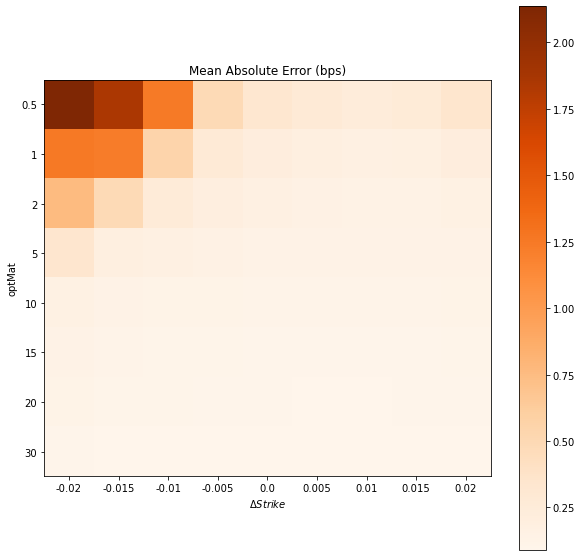

In [11]:
# Plot Error on a subset 

subsetIdx = X_te[(X_te["sigma"]>0.005) & (X_te["sigma"]<0.02)].index
X_subset = X_te_clean[subsetIdx]
y_subset = y_te.iloc[subsetIdx]

pred_subset = model.predict(X_subset)
pred_subset = scaleY.inverse_transform(pred_subset)

error = 10000 * np.mean(np.abs(pred_subset - y_subset.values), axis=0) # Absolute error in bps
errDf = pd.DataFrame(error.reshape(len(strike), len(optMats)).T, index=optMats, columns=np.around(strike,4))

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(errDf, cmap="Oranges")
plt.colorbar()
ax.set_xticks(range(0,len(strike)))
ax.set_xticklabels(np.around(strike,3))
ax.set_yticks(range(0, len(optMats)))
ax.set_yticklabels(optMats)
ax.set_xlabel(r"$\Delta Strike$")
ax.set_ylabel("optMat")
plt.title("Mean Absolute Error (bps)")
plt.savefig("plots/trimSigma-matrixMeanAbsError-bps.png")
plt.show()

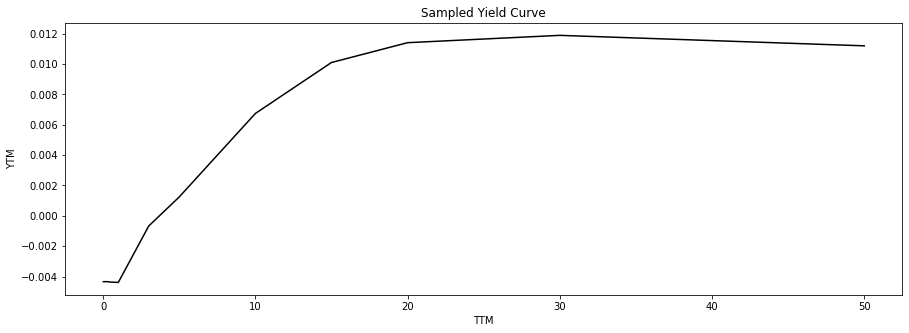

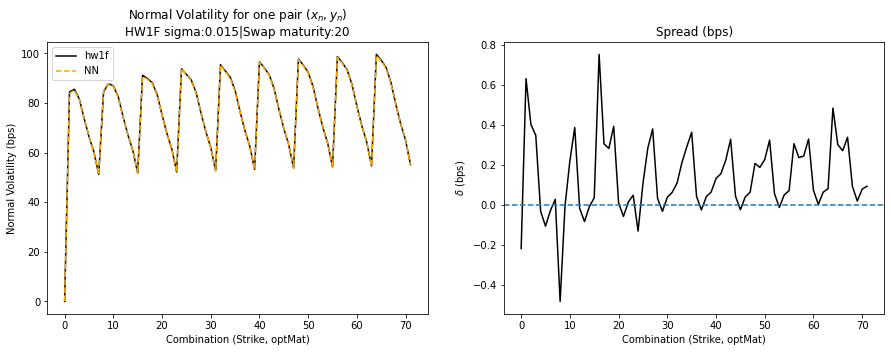

In [12]:
pool = X_te[(X_te["sigma"] < 0.016 )& (X_te["sigma"] > 0.014) & (X_te["swapMat"]==20)].index.values
maturities = np.array([7/360, 30/360, 90/360, 180/360, 1, 3, 5, 10, 15, 20, 30, 50])

bpsConversion = 10000
# Plot metrics for a single sample
randomIdx = np.random.choice(pool)
sample_y = y_te.iloc[randomIdx].values * bpsConversion
sample_pred = pred_oos[randomIdx] * bpsConversion

sigma, swapMat = X_te.loc[randomIdx, 'sigma'], X_te.loc[randomIdx, 'swapMat']

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(maturities, X_te[curveCols].iloc[randomIdx], color="black")
ax.title.set_text("Sampled Yield Curve")
ax.set_ylabel("YTM")
ax.set_xlabel("TTM")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(sample_y, label="hw1f", color="black")
ax1.plot(sample_pred, label="NN", ls="--", color="orange")
ax1.legend()
ax1.title.set_text("Normal Volatility for one pair "+r"$(x_n, y_n)$"+f"\nHW1F sigma:{sigma:.3f}|Swap maturity:{swapMat}")
ax1.set_xlabel("Combination (Strike, optMat)")
ax1.set_ylabel("Normal Volatility (bps)")
ax2.plot((sample_y - sample_pred), color="black")
ax2.title.set_text("Spread (bps)")
ax2.axhline(0, ls="--")
ax2.set_xlabel("Combination (Strike, optMat)")
ax2.set_ylabel(r"$\delta$ (bps)")

plt.savefig("plots/errorOneSample-NN_HW1F.png")
plt.show()

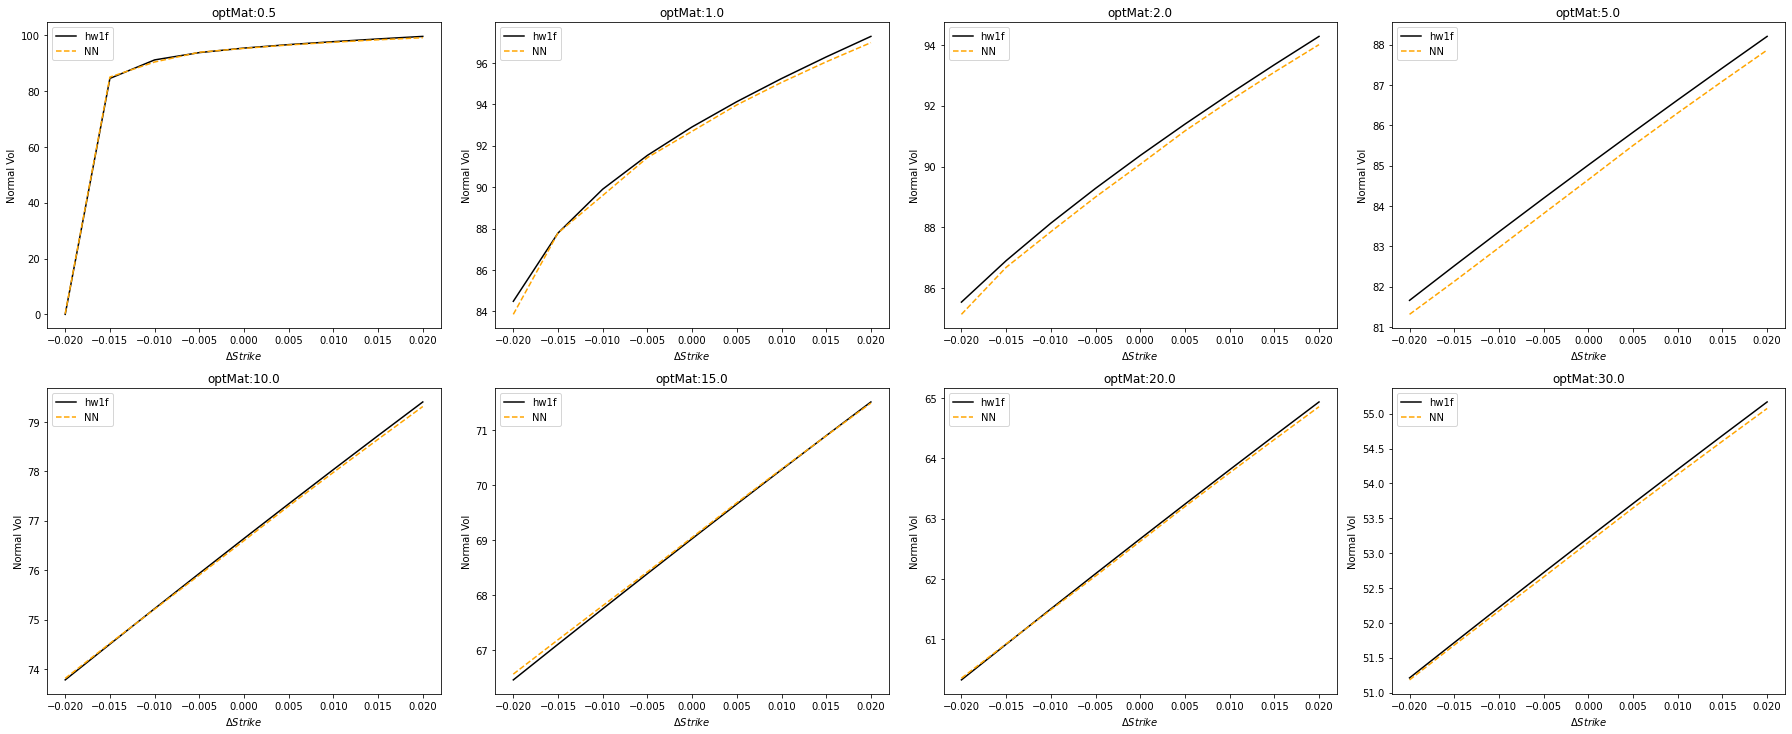

In [13]:
# HW1F implied smile
plt.figure(1, figsize=(25,20))
for ii, optMat in enumerate(combinations["optMat"].unique()):
    lkp = combinations[(combinations["optMat"]==optMat)]
    y_vol, pred_vol = sample_y[lkp.index], sample_pred[lkp.index]
    
    plt.subplot(4, 4, ii+1)
    plt.plot(lkp["chgStrike"], y_vol,label="hw1f", color="black")
    plt.plot(lkp["chgStrike"], pred_vol, label="NN", ls="--", color="orange")
    plt.xlabel(r"$\Delta Strike$")
    plt.ylabel("Normal Vol")
    plt.legend()
    plt.title(f"optMat:{optMat}")

plt.tight_layout()
plt.savefig("plots/hw1fSmile.png")
plt.show()

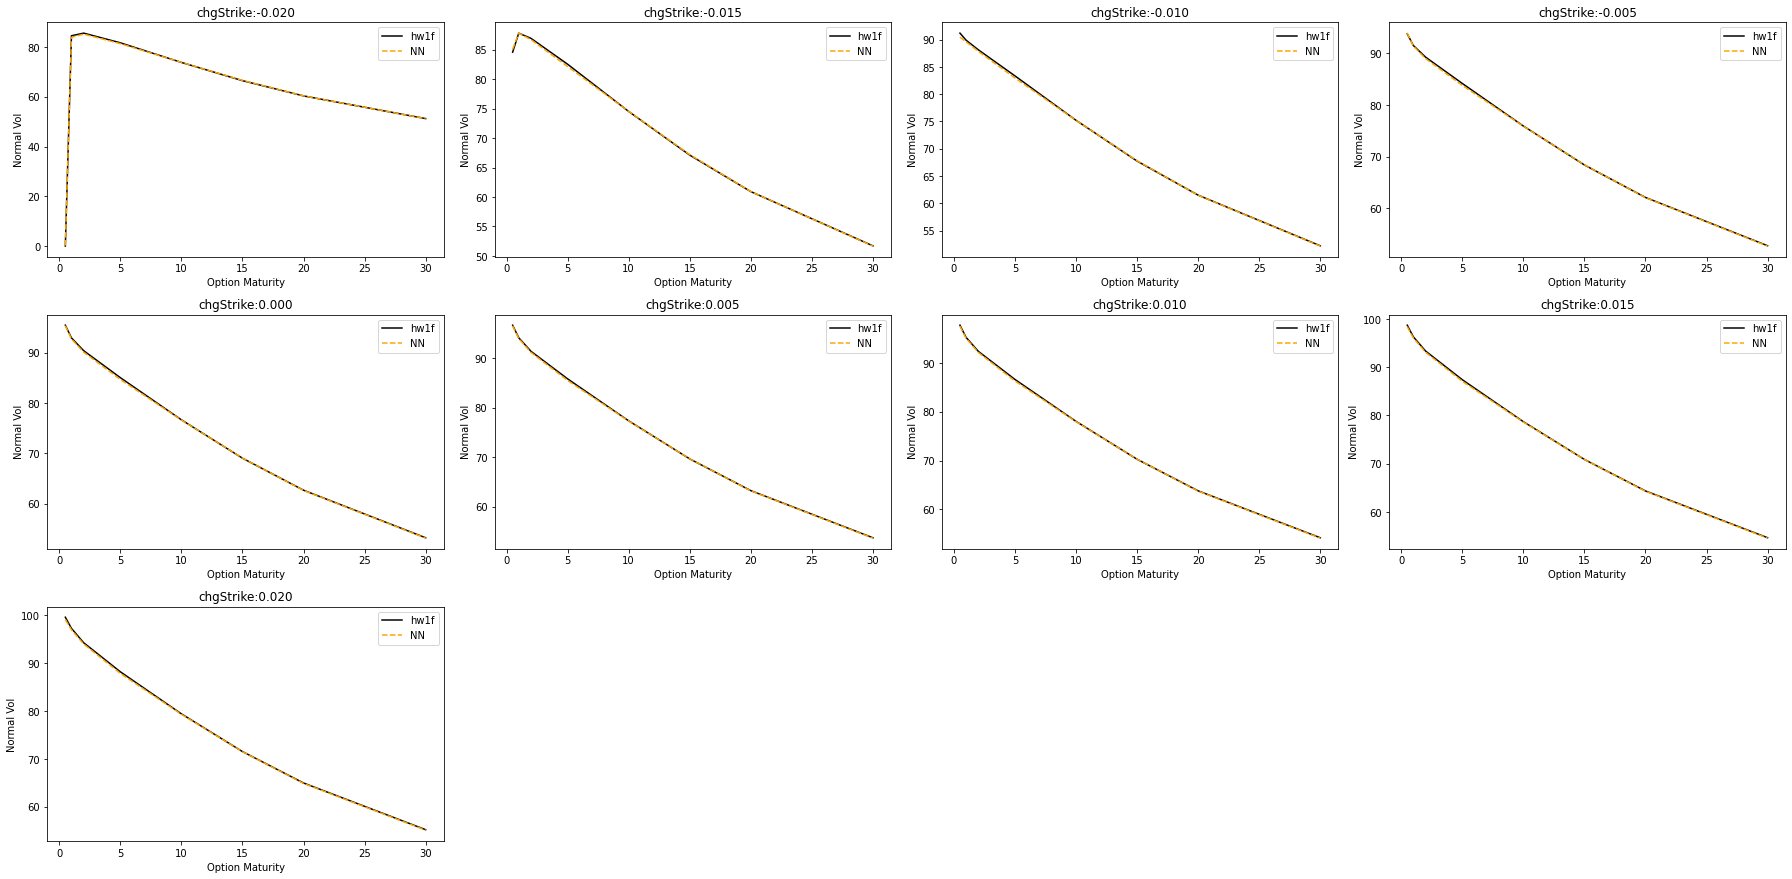

In [14]:
# Plot time dependency
plt.figure(1, figsize=(25, 20))
for ii, chgStrike in enumerate(combinations["chgStrike"].unique()):
    lkp = combinations[(combinations["chgStrike"]==chgStrike)]
    y_vol, pred_vol = sample_y[lkp.index], sample_pred[lkp.index]
    
    plt.subplot(5, 4, ii+1)
    plt.plot(lkp["optMat"], y_vol, label="hw1f", color="black")
    plt.plot(lkp["optMat"], pred_vol,label="NN", ls="--", color="orange")
    plt.legend()
    plt.xlabel("Option Maturity")
    plt.ylabel("Normal Vol")
    plt.title(f"chgStrike:{chgStrike:.3f}")
plt.tight_layout()
plt.savefig("plots/hw1fTimeDep.png")
plt.show()